# HIV Inhibitor prediction using GNN on Amazon SageMaker

## Motivation :

The human immunodeficiency virus type 1 (HIV-1) is the primary cause of the acquired immunodeficiency syndrome (AIDS), which is a slow, progressive and degenerative disease of the human immune system. The pathogenesis of HIV-1 is complex and characterized by the interplay of both viral and host factors. An intense global research effort into understanding the individual steps of the viral replication cycle and the dynamics during an infection has inspired researchers in the development of a wide spectrum of antiviral strategies.

![Inhibitor](img/1.jpg)
<div style="text-align: center">
<font size=1> 
Image Source : Biological evaluation of molecules of the azaBINOL class as antiviral agents (https://www.sciencedirect.com/science/article/abs/pii/S0968089619306704)
 </font>
</div>

<br/>
<br/>
<br/>

The purpose of this effort here is to predict the target molecular properties as accurately as possible, where the molecular properties are cast as binary labels, e.g, whether a molecule inhibits HIV virus replication or not, using Graph machine learning techniques which can leveraged as a virtual screening step.


### DGL :

Deep Graph Library (DGL) is a Python package built for easy implementation of graph neural network model family, on top of existing DL frameworks (currently supporting PyTorch, MXNet and TensorFlow). It offers a versatile control of message passing, speed optimization via auto-batching and highly tuned sparse matrix kernels, and multi-GPU/CPU training to scale to graphs of hundreds of millions of nodes and edges.

https://www.dgl.ai/


### DGL Life Science : 

DGL Life Sciences is an abstraction library built on top of DGL with the aim of bringing Graph Neural Networks to Chemistry and Biology.
It is a python package for applying graph neural networks to various tasks in chemistry and biology, on top of PyTorch and DGL. 

It provides:

* Various utilities for data processing, training and evaluation.

* Efficient and flexible model implementations.

* Pre-trained models for use without training from scratch.


## Notebook Overview

This example notebook focuses on training multiple Graph neural network models using Deep Graph Librar and deploying it using Amazon SageMaker, which is a  comprehensive and fully managed machine learning service. With SageMaker, data scientists and developers can quickly and easily build and train machine learning models, and then directly deploy them into a production-ready hosted environment. 

**Note:** Please select the Kernel as Python 3 (Pytorch 1.6 Python 3.6 CPU Optimized).



### setup

Let's start by installing dgl libraries latest sagemaker version and importinn some Python libraries.

In [7]:
%pip install --quiet dgl
%pip install --quiet dgllife
%pip install -U --quiet sagemaker=="2.75.1"
%pip install --quiet rdkit-pypi

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
from functools import partial
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

import dgl

from dgllife.model import load_pretrained
from dgllife.utils import smiles_to_bigraph, EarlyStopping, Meter, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from functools import partial
from torch.optim import Adam
from torch.utils.data import DataLoader

from dgllife.data import HIV

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

Using backend: pytorch


In [9]:
rdkit.__version__

'2021.09.4'

In [10]:
node_featurizer = CanonicalAtomFeaturizer(atom_data_field='feat')
edge_featurizer = None#CanonicalBondFeaturizer(bond_data_field='feat1')
num_workers = 1
split_ratio = "0.7:0.2:0.1"

### Dataset

The HIV dataset was introduced by the Drug Therapeutics Program (DTP) AIDS Antiviral Screen, which tested the ability to inhibit HIV replication for over 40,000 compounds. Screening results were evaluated and placed into three categories: confirmed inactive (CI),confirmed active (CA) and confirmed moderately active (CM). We further combine the latter two labels, making it a classification task between inactive (CI) and active (CA and CM).

While the row dataset can be downloaded from here (https://moleculenet.org/datasets-1) , DGL-LifeSci library provides an highlevel interface to download the dataset as part of it's Datasets package (https://lifesci.dgl.ai/api/data.html#hiv). 

In [11]:
dataset = HIV(smiles_to_graph=partial(smiles_to_bigraph, add_self_loop=True),
                  node_featurizer=node_featurizer,
                  edge_featurizer=edge_featurizer,
                  n_jobs=num_workers)

Processing dgl graphs from scratch...
Processing molecule 1000/41127
Processing molecule 2000/41127
Processing molecule 3000/41127
Processing molecule 4000/41127
Processing molecule 5000/41127
Processing molecule 6000/41127
Processing molecule 7000/41127
Processing molecule 8000/41127
Processing molecule 9000/41127
Processing molecule 10000/41127
Processing molecule 11000/41127
Processing molecule 12000/41127
Processing molecule 13000/41127
Processing molecule 14000/41127
Processing molecule 15000/41127
Processing molecule 16000/41127
Processing molecule 17000/41127
Processing molecule 18000/41127
Processing molecule 19000/41127
Processing molecule 20000/41127
Processing molecule 21000/41127
Processing molecule 22000/41127
Processing molecule 23000/41127
Processing molecule 24000/41127
Processing molecule 25000/41127
Processing molecule 26000/41127
Processing molecule 27000/41127
Processing molecule 28000/41127
Processing molecule 29000/41127
Processing molecule 30000/41127
Processing 

In [12]:
type(dataset)

dgllife.data.hiv.HIV

### Explore the dataset

In [13]:
dataset.df.shape

(41127, 2)

In [14]:
dataset.df.head(15)

,smiles,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0
4,O=S(=O)(O)CCS(=O)(=O)O,0
5,CCOP(=O)(Nc1cccc(Cl)c1)OCC,0
6,O=C(O)c1ccccc1O,0
7,CC1=C2C(=COC(C)C2C)C(O)=C(C(=O)O)C1=O,0
8,O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+]...,0
9,O=[N+]([O-])c1ccccc1SSc1ccccc1[N+](=O)[O-],0


* Dataset containes ~41K molecules in `smiles` format.
* The `HIV_active` column (label) indicates that the molecule is a suitable HIV inhibitor or not. 

First, let's verify if there are any missing values in the dataset.

In [15]:
dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41127 entries, 0 to 41126
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   smiles      41127 non-null  object
 1   HIV_active  41127 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 642.7+ KB


In [16]:
dataset.df.isnull().values.any()

False

As you can see, there are `no` missing values in this dataset. Then let's explore the class distribution of the dataset.

In [17]:
dataset.df['HIV_active'].value_counts()

0    39684
1     1443
Name: HIV_active, dtype: int64

<AxesSubplot:>

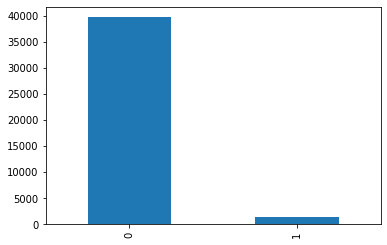

In [18]:
dataset.df['HIV_active'].value_counts().plot(kind='bar')

* Dataset is heavily imbalaced as there are only ~3% compounts were screened as HIV inhibtiors.

### Explore molecules (with RDKit)

The RDKit is an open-source cheminformatics toolkit. It includes a collection of standard cheminformatics functionality for molecule I/O, substructure searching, chemical reactions, coordinate generation (2D or 3D), fingerprinting, etc.

We are going to use this library to explore the molecules (presented in smiles format) in the dataset. Following are few ramdomly selected molecules from the dataset visualized using RDKit

https://www.rdkit.org/docs/cppapi/index.html

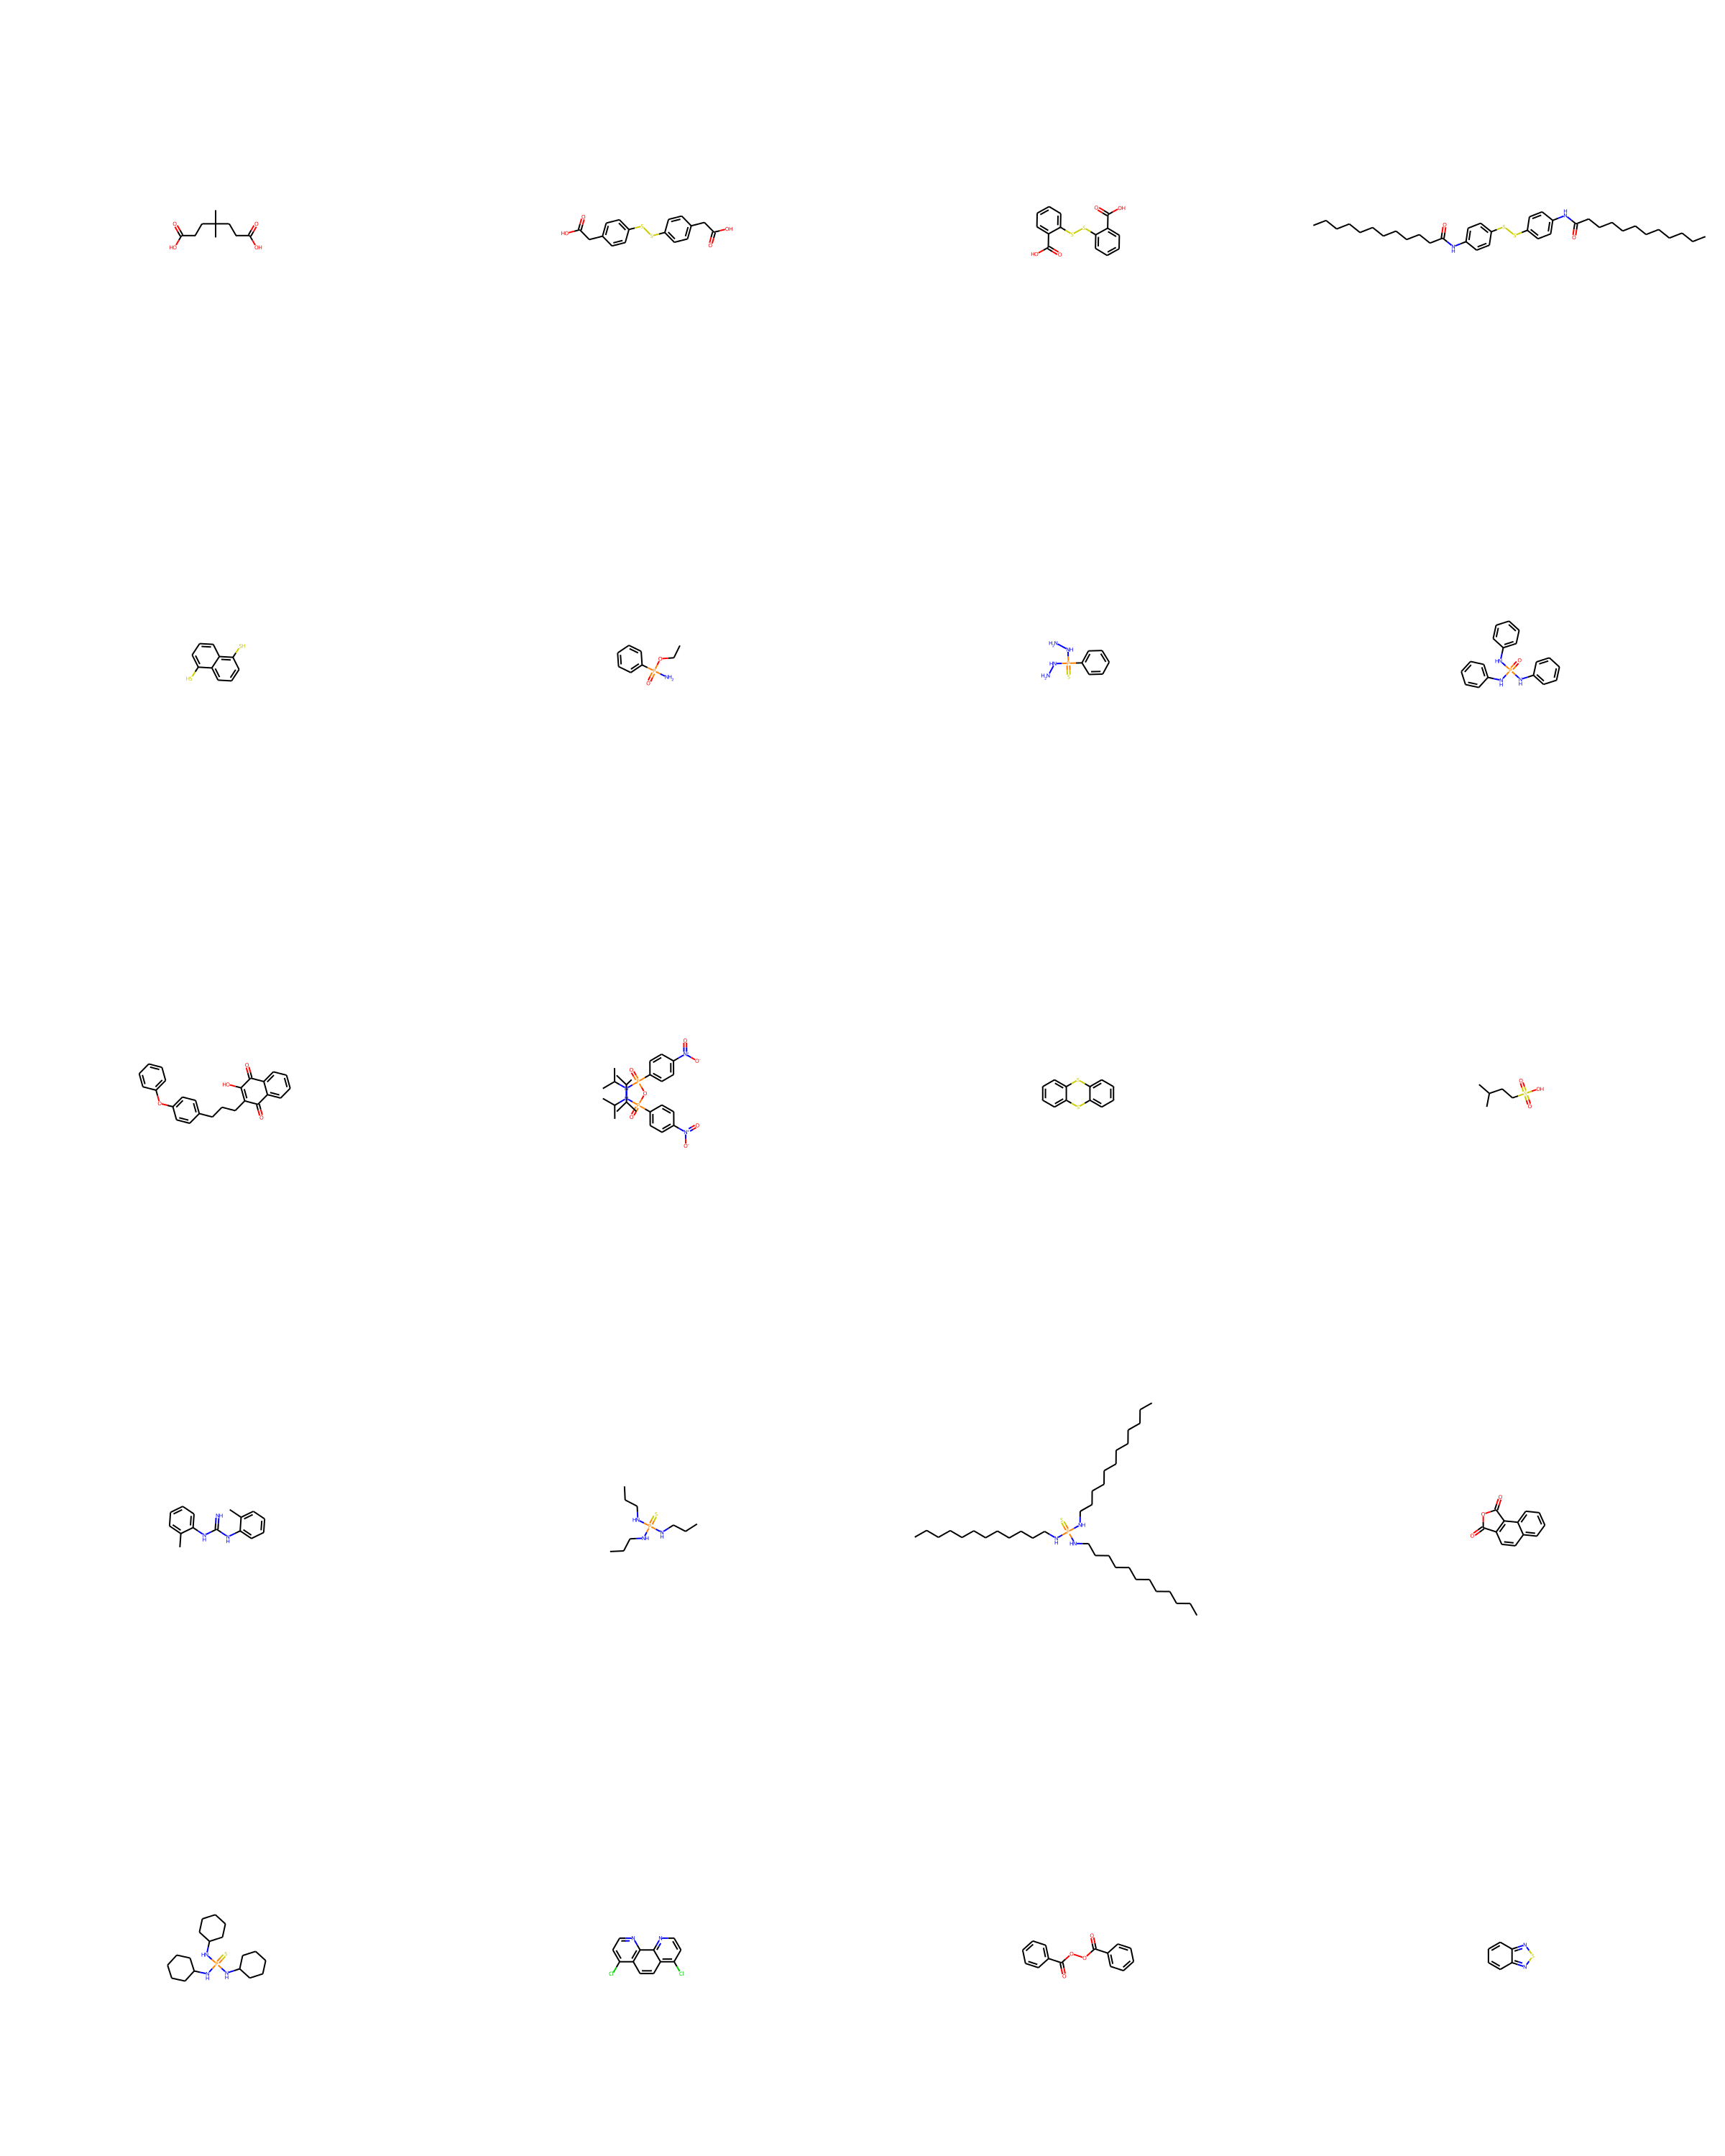

In [19]:
random_molecule_start_index = 10

sample_smiles = dataset.df['smiles'][random_molecule_start_index:random_molecule_start_index + 20].values
sample_molecules = [Chem.MolFromSmiles(smile) for smile in sample_smiles]
Draw.MolsToGridImage(sample_molecules, molsPerRow=4, subImgSize=(600, 600))

* Let's look at a single molecule and explore the properties.

In [20]:
sample_smiles[0]

'CC(C)(CCC(=O)O)CCC(=O)O'

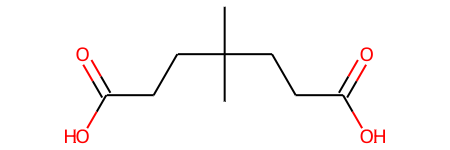

In [21]:
mol = sample_molecules[0]
mol

* Using the methods here we can further explore the features of the molecules.
https://www.rdkit.org/docs/cppapi/classRDKit_1_1Atom.html

In [22]:
atoms = mol.GetAtoms()
print("Total number of atoms in the molecule : {}".format(len(atoms)))

Total number of atoms in the molecule : 13


In [23]:
molecule_features = []
for atom in atoms:
    atom_features = {}
    atom_features['atomic_symbol'] = atom.GetSymbol()
    atom_features['atomic_numbers'] = atom.GetAtomicNum()
    atom_features['degree'] = atom.GetDegree()
    atom_features['formal_charge'] = atom.GetFormalCharge()
    atom_features['hybridization'] = atom.GetHybridization()
    atom_features['is_aromatic'] = atom.GetIsAromatic()
    molecule_features.append(atom_features)
molecule_features

[{'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 1,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 4,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 1,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 2,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 2,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3,
  'is_aromatic': False},
 {'atomic_symbol': 'C',
  'atomic_numbers': 6,
  'degree': 3,
  'formal_charge': 0,
  'hybridization': rdkit.Chem.rdchem.HybridizationType.SP2,
  'is_aroma

* We can apply node-fearizer directly into the molecule like below and generate above results.

In [24]:
atom_featurizer = CanonicalAtomFeaturizer(atom_data_field='feat')
atom_featurizer(mol)

{'feat': tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
          0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.

In [25]:
atom_featurizer.feat_size()

74

We already have these embedded to our graph since we have used the node featurizer at the top. 

https://lifesci.dgl.ai/generated/dgllife.utils.CanonicalAtomFeaturizer.html

Let's decode the graph associated to above index

In [26]:
smiles, graphs, labels, masks = map(list, zip(*dataset))

In [27]:
smiles[random_molecule_start_index]

'CC(C)(CCC(=O)O)CCC(=O)O'

In [28]:
random_graph = graphs[random_molecule_start_index]

random_graph.num_nodes()

13

In [29]:
random_graph.num_edges()

37

In [30]:
random_graph.ndata['feat'].shape

torch.Size([13, 74])

In [31]:
random_graph.ndata['feat'][0, :]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0.])

In [32]:
random_graph.ndata['feat'][1, :]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.])

Order of the atoms represented in the graph is different (This is a not an problem). 

### Split the dataset

DGL-LifeSci provides interfaces to split your data for train, validation and test sets based on the strategy that you prefer. 
More details : https://lifesci.dgl.ai/api/utils.splitters.html

We are going to use the Scaffold Splitter for this project. 

**ScaffoldSplitter**:

Group molecules based on their scaffolds and sort groups based on their sizes. The groups are then split for k-fold cross validation.

Same as usual k-fold splitting methods, each molecule will appear only once in the validation set among all folds. In addition, this method ensures that molecules with a same scaffold will be collectively in either the training set or the validation set for each fol

In [33]:
#Split the dataset
from dgllife.utils import ScaffoldSplitter, RandomSplitter

train_ratio, val_ratio, test_ratio = map(float, split_ratio.split(':'))

train_set, val_set, test_set = ScaffoldSplitter.train_val_test_split(
            dataset, frac_train=train_ratio, frac_val=val_ratio, frac_test=test_ratio,
            scaffold_func='smiles')

Start initializing RDKit molecule instances...
Creating RDKit molecule instance 1000/41127
Creating RDKit molecule instance 2000/41127
Creating RDKit molecule instance 3000/41127
Creating RDKit molecule instance 4000/41127
Creating RDKit molecule instance 5000/41127
Creating RDKit molecule instance 6000/41127
Creating RDKit molecule instance 7000/41127
Creating RDKit molecule instance 8000/41127
Creating RDKit molecule instance 9000/41127
Creating RDKit molecule instance 10000/41127
Creating RDKit molecule instance 11000/41127
Creating RDKit molecule instance 12000/41127
Creating RDKit molecule instance 13000/41127
Creating RDKit molecule instance 14000/41127
Creating RDKit molecule instance 15000/41127
Creating RDKit molecule instance 16000/41127
Creating RDKit molecule instance 17000/41127
Creating RDKit molecule instance 18000/41127
Creating RDKit molecule instance 19000/41127
Creating RDKit molecule instance 20000/41127
Creating RDKit molecule instance 21000/41127
Creating RDKit mo

* Lets check the distribution of classes of train, validation, test datasets after the split.

In [34]:
len(train_set)

28788

<AxesSubplot:>

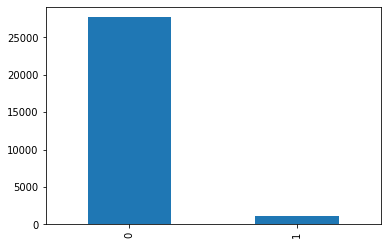

In [35]:
train_set.dataset.df.loc[train_set.indices]['HIV_active'].value_counts().plot(kind="bar")

In [36]:
len(val_set)

8226

<AxesSubplot:>

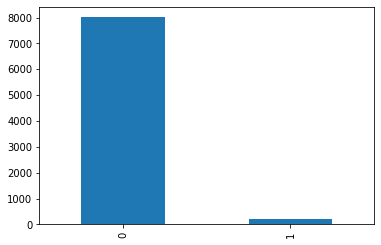

In [37]:
val_set.dataset.df.loc[val_set.indices]['HIV_active'].value_counts().plot(kind="bar")

In [38]:
len(test_set)

4113

<AxesSubplot:>

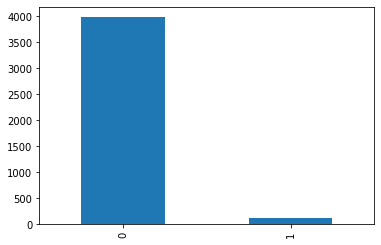

In [39]:
test_set.dataset.df.loc[test_set.indices]['HIV_active'].value_counts().plot(kind="bar")

* All three datasets (train, test, validation) follows the same data distrubtions in terms of class balance.

## Using DGL in Amazon Sagemaker with Pytorch backend.

#### Set up the environment and create the session

Here we specify a bucket to use and the role that will be used for working with SageMaker. The session remembers our connection parameters to SageMaker.


In [40]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
session = sagemaker.Session()
bucket = session.default_bucket()

s3_prefix = "./hiv_inhibitor_prediction/sagemaker"

### Upload Data to S3
In order to accomodate model training on SageMaker we need to upload the data to s3 location. We are going to use the sagemaker.Session.upload_data function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use later when we start the training job.

In [41]:
dataset.df.to_csv("full.csv", index=False)
pd.DataFrame(train_set.indices, columns =["indices"]).to_csv("train.csv", index=False)
pd.DataFrame(val_set.indices, columns =["indices"]).to_csv("validation.csv", index=False)

In [42]:
input_full = session.upload_data(
        path="full.csv", bucket=bucket, key_prefix=s3_prefix
    )

input_train = session.upload_data(
        path="train.csv", bucket=bucket, key_prefix=s3_prefix
    )
input_val = session.upload_data(
        path="validation.csv", bucket=bucket, key_prefix=s3_prefix
    )

### Explore the model architectures to be used 

We are going to represent each of the modelcule as a graph. Each atom in the molecule would be a node within the graph. Hence the atom properties will be considered as node features after doing some transformations. Using these features we are going to classify the whole graph/molecule whether a it inhibits HIV virus replication or not using Graph neural networks (GNNs). In GNN terms this is considered as Graph classification problem.

We are going to use above prebuilt model architecures (GCN, GAT) which comes with DGL-LifeSci to train the model.


**1. GCNPredictor** : 

Documentation : https://lifesci.dgl.ai/_modules/dgllife/model/model_zoo/gcn_predictor.html

Code : https://github.com/awslabs/dgl-lifesci/blob/master/python/dgllife/model/model_zoo/gcn_predictor.py

In [43]:
from dgllife.model import GCNPredictor
import torch.nn.functional as F

model = GCNPredictor(
            in_feats=10,
            hidden_feats=[10, 4],
            activation=[F.relu, F.relu],
            residual=[False] * 2
            )

In [44]:
model

GCNPredictor(
  (gnn): GCN(
    (gnn_layers): ModuleList(
      (0): GCNLayer(
        (graph_conv): GraphConv(in=10, out=10, normalization=none, activation=<function relu at 0x7fd01e967400>)
        (dropout): Dropout(p=0.0, inplace=False)
        (bn_layer): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GCNLayer(
        (graph_conv): GraphConv(in=10, out=4, normalization=none, activation=<function relu at 0x7fd01e967400>)
        (dropout): Dropout(p=0.0, inplace=False)
        (bn_layer): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (readout): WeightedSumAndMax(
    (weight_and_sum): WeightAndSum(
      (atom_weighting): Sequential(
        (0): Linear(in_features=4, out_features=1, bias=True)
        (1): Sigmoid()
      )
    )
  )
  (predict): MLPPredictor(
    (predict): Sequential(
      (0): Dropout(p=0.0, inplace=False)
      (1): Linear(in_features=8, out_features=128,

As you can see `GCNPredictor` architecture compised of multple layers of `gnn_layers` which itself comprised of DGL `GraphConv`.

## Training on SageMaker



#### Training Script

We are going to use Pytorch as the DGL backend. Our training script should save model artifacts learned during training to a file path called model_dir, as stipulated by the SageMaker PyTorch image. Upon completion of training, model artifacts saved in model_dir will be uploaded to S3 by SageMaker and will be used for deployment.

We save this script in a file named train.py, and put the file in a directory named code/. The full training script can be viewed under code/.
    
    

In [45]:
!cat code/train.py

import argparse
import os
import json

import dgl
import numpy as np
import pandas as pd
import torch
from dgllife.utils import EarlyStopping, Meter
from numpy import double
from torch.optim import Adam
from torch.utils.data import DataLoader
from utils import load_model, init_featurizers, model_saved_path, model_params_saved_path
from s3_downloaded_HIV_dataset import S3DownloadedHIVDataset


def run_a_train_epoch(args, epoch, model, data_loader, loss_criterion, optimizer, device):
    model.train()
    train_meter = Meter()
    for batch_id, batch_data in enumerate(data_loader):
        smiles, bg, labels, masks = batch_data
        if len(smiles) == 1:
            # Avoid potential issues with batch normalization
            continue

        labels, masks = labels.to(device), masks.to(device)
        logits = predict(model, bg, device)
        # Mask non-existing labels
        loss = (loss_criterion(logits, labels) * (masks != 0).float()).mean()
        optimizer.zero_grad()
      

#### Create an experiment

When training with SageMaker it is a good idea to track all the trails that we do to come up with better model under a single colelction. Hence later we would be able compare each of the trails. That colelction is called SageMaker experiments.

In [46]:
%pip install sagemaker-experiments --quiet

Note: you may need to restart the kernel to use updated packages.


In [47]:
from smexperiments.experiment import Experiment

experiment_name = "HIV-Inhibitor-Prediction-Experiment"

try :
    experiment = Experiment.load(experiment_name)
except Exception as e:
    if e.response['Error']['Code'] == "ResourceNotFound":
        print("Experiment name [{}], does not exists. Hence creating.".format(experiment_name))
        experiment = Experiment.create(experiment_name = experiment_name,
                                description = "Experiment to track all the hiv inhibitr prediction trails.")
    else:
        raise e
experiment                               

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7fcfd5d84f28>,experiment_name='HIV-Inhibitor-Prediction-Experiment',experiment_arn='arn:aws:sagemaker:us-west-2:431678540810:experiment/hiv-inhibitor-prediction-experiment',display_name='HIV-Inhibitor-Prediction-Experiment',description='Experiment to track all the hiv inhibitr prediction trails.',creation_time=datetime.datetime(2022, 2, 23, 23, 54, 47, 296000, tzinfo=tzlocal()),created_by={'UserProfileArn': 'arn:aws:sagemaker:us-west-2:431678540810:user-profile/d-6awzisu1lq0k/shamika-dev0', 'UserProfileName': 'shamika-dev0', 'DomainId': 'd-6awzisu1lq0k'},last_modified_time=datetime.datetime(2022, 3, 16, 1, 32, 34, 893000, tzinfo=tzlocal()),last_modified_by={},response_metadata={'RequestId': '92100d35-24b3-4d89-95bd-6e6c188fa775', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '92100d35-24b3-4d89-95bd-6e6c188fa775', 'content-type': 'application/x-amz-json-1.1', 'content-length': '554', 'date': 'Wed, 16 M

#### Define hyper parameters

Next, let's define hyper parameters assocated with the model. As per training script we created above here are some of the hyper parameters that we can use to tune our model(s). One highlight here is that the model architecture is also given here as the hyper parameter which allows other model architecutures like GAT, MPNN. 

In [48]:
from sagemaker.pytorch import PyTorch
import time

hyperparameters={
    # Feature Engineering
    "gnn-featurizer-type": 'canonical',
    
    # Model Architecture
    "gnn-model-name" : 'GCN-p',
    "gnn-residuals" : False,
    "gnn-batchnorm" : True,
    "gnn-dropout" : 0.0013086019242321,
    "gnn-predictor-hidden-feats" : 512,
    
    # Training
    "batch-size" : 512,
    "epochs" : 1000,
    "learning-rate" : 0.000508635928951698,
    "weight-decay" : 0.0013253058161908312,
    "patience" : 30
}

metric_definitions =[
                   {'Name': 'train:roc_auc_score', 'Regex': 'training:roc_auc_score\s\[([0-9\\,.]+)\]'},
                   {'Name': 'validation:roc_auc_score', 'Regex': ',\svalidation:roc_auc_score\s\[([0-9\\,.]+)\]'},
                   {'Name': 'best validation:roc_auc_score', 'Regex': 'best\svalidation:roc_auc_score\s\[([0-9\\,.]+)\]'},
                   {'Name': 'epoch', 'Regex': 'epoch\s\[([0-9]+)\]'},
                   {'Name': 'train:loss', 'Regex': 'loss\s\[([0-9\\,.]+)\]'}
                ]



#### Create trial

From here onwards each model training that we are going to perform will be tracked under the experiement that we created above as a seperate trail.

In [49]:
trial_name = "hiv-inhibitor-prediction-trainning-{}-{}".format(hyperparameters["gnn-model-name"], time.strftime("%m-%d-%Y-%H-%M-%S"))
trial = experiment.create_trial(trial_name=trial_name)

### Train

DGL expects a neural network runtime and supports all Tensorlow, Pytorch and MxNext as it's runtimes. For for this project we are going to use `Pytorch` as the backend.

The Amazon SageMaker Python SDK makes it easier to run a PyTorch script in Amazon SageMaker using its PyTorch estimator. After that, we can use the SageMaker Python SDK to deploy the trained model and run predictions. For more information on how to use this SDK with PyTorch, see the SageMaker Python SDK documentation.

To start, we use the PyTorch estimator class to train our model. When creating our estimator, we make sure to specify a few things:

* `entry_point`: the name of our PyTorch script. It contains our training script, which loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model. It also contains code to load and run the model during inference.

* `source_dir`: the location of our training scripts and requirements.txt file. "requirements.txt" lists packages you want to use with your script.

* `framework_version`: the PyTorch version we want to use.
The PyTorch estimator supports both single-machine & multi-machine, distributed PyTorch training using SMDataParallel

In [50]:
training_job_name = "tr-{}".format(trial_name) 
print('Training job name: ', training_job_name)

estimator = PyTorch(
    entry_point = "train.py",
    source_dir = "code",
    role = role,
    framework_version = "1.9.0",
    py_version="py38",
    instance_count=2,
    instance_type="ml.p3.2xlarge",
    debugger_hook_config=False,
    disable_profiler=True,
    hyperparameters = hyperparameters,
    metric_definitions=metric_definitions
)

estimator.fit({"data_full" : input_full, "data_train" : input_train, "data_val" : input_val}, 
              job_name = training_job_name,
             experiment_config = {
                    # "ExperimentName"
                    "TrialName" : trial.trial_name,
                    "TrialComponentDisplayName" : "TrainingJob",
                })

Training job name:  tr-hiv-inhibitor-prediction-trainning-GCN-p-03-16-2022-02-15-29


INFO:sagemaker:Creating training-job with name: tr-hiv-inhibitor-prediction-trainning-GCN-p-03-16-2022-02-15-29


2022-03-16 02:15:30 Starting - Starting the training job......
2022-03-16 02:16:06 Starting - Preparing the instances for training......
2022-03-16 02:17:27 Downloading - Downloading input data
2022-03-16 02:17:27 Training - Downloading the training image..........................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-16 02:21:41,598 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-16 02:21:41,620 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-16 02:21:41,626 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-03-16 02:21:42,084 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
Preparing metadata (setup.py): started
Preparing metadata (setup.py): finished with status 'done'
bash: cannot 

### Training results :

* As you can see with the initial training here we get about 76% AUC value. How the metrics like training loss, validation loss and roc score changed over the time can be viewed on the SageMaker experiements.

Before, we deploy the model to an endpoint, let's see the where the model trained arffacts are stored in S3.


In [51]:
#model_data='s3://sagemaker-us-west-2-431678540810/tr-hiv-inhibitor-prediction-trainning-GCN-p-02-27-2022-22-25-51/output/model.tar.gz'
model_data = estimator.model_data
print("Stored {} as model_data".format(model_data))

Stored s3://sagemaker-us-west-2-431678540810/tr-hiv-inhibitor-prediction-trainning-GCN-p-03-16-2022-02-15-29/output/model.tar.gz as model_data


## Deploy the model on Amazon SageMaker
After training our model, we host it on an Amazon SageMaker Endpoint. To make the endpoint load the model and serve predictions, we implement a few methods in inference.py.

* `model_fn()`: function defined to load the saved model and return a model object that can be used for model serving. The SageMaker PyTorch model server loads our model by invoking model_fn.
* `input_fn()`: deserializes and prepares the prediction input. In this example, our request body is first serialized to JSON and within the JSON it expects the `smiles` of the molecules that needs to be predicted. The input of smiles first converts graph using DGL and then add the features to each node using the same featurizer used at the time of training. Then the graph with features is returned by this function which is the requested format by the model. 
* `predict_fn()`: performs the prediction and returns the result. To deploy our endpoint, we call deploy() on our PyTorch estimator object, passing in our desired number of instances and instance type:

In [52]:
from sagemaker.pytorch import PyTorchModel

endpoint_name = "HIV-Inhibitor-Prediction-EP-{}".format(time.strftime("%m-%d-%Y-%H-%M-%S"))
print("Endpoint name: ", endpoint_name)

model = PyTorchModel(model_data=model_data, source_dir='code',
                        entry_point='inference.py', role=role, framework_version="1.9.0", py_version='py38')



Endpoint name:  HIV-Inhibitor-Prediction-EP-03-16-2022-02-31-55


In [53]:
predictor = model.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge", endpoint_name=endpoint_name)

INFO:sagemaker:Creating model with name: pytorch-inference-2022-03-16-02-31-56-489
INFO:sagemaker:Creating endpoint-config with name HIV-Inhibitor-Prediction-EP-03-16-2022-02-31-55
INFO:sagemaker:Creating endpoint with name HIV-Inhibitor-Prediction-EP-03-16-2022-02-31-55


------!

## Predicting test_set with the endpoint :

As our newly created endpoint expects the smiles as the input let's get the all the smiles of the test_set. We can use followng function for that.

In [54]:
def collate_molgraphs(data):
    """Batching a list of datapoints for dataloader.
    Parameters
    ----------
    data : list of 4-tuples.
        Each tuple is for a single datapoint, consisting of
        a SMILES, a DGLGraph, all-task labels and optionally a binary
        mask indicating the existence of labels.
    Returns
    -------
    smiles : list
        List of smiles
    bg : DGLGraph
        The batched DGLGraph.
    labels : Tensor of dtype float32 and shape (B, T)
        Batched datapoint labels. B is len(data) and
        T is the number of total tasks.
    masks : Tensor of dtype float32 and shape (B, T)
        Batched datapoint binary mask, indicating the
        existence of labels.
    """

    smiles, graphs, labels, masks = map(list, zip(*data))
    
    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)
    masks = torch.stack(masks, dim=0)

    return smiles, bg, labels, masks

Using that function let's get all the smiles in the test set.

In [55]:
test_smiles, bg, test_labels, masks = collate_molgraphs(test_set)

### Predicting for a single molecule :

Let's use single molecule from the test set and predict the probability of its beeing and inhibitor using the newly created endpoint above. Here is a randomly selected molecule. 

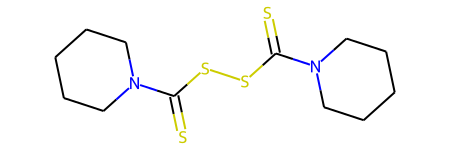

In [56]:
mol = Chem.MolFromSmiles(test_smiles[110])
mol

Let's send this molecule data as JSON format to the endpoint and get the results.

In [57]:
from sagemaker.predictor import Predictor

predictor = Predictor(endpoint_name=endpoint_name)

predictor.serializer = sagemaker.serializers.JSONSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

In [58]:
json = {
    "smiles" : 
        [test_smiles[110]]
}

prediction_logits = predictor.predict(json)
prediction_logits

[-4.612298011779785]

This had returned the logit value of above molecule beeing considered as an inhibitor.

### Predicting for a for whole test_set :


In [59]:
json = {
    "smiles" : 
        test_smiles
}

prediction_logits = predictor.predict(json)

### Examine the test results 

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt 

roc_auc_score(test_labels[:,0].numpy(), np.asarray(prediction_logits))

0.7742636976380387

* We get the ROC/AUC score for test set with the initial model aroinf 0.75.
* Below is the ROC Curve

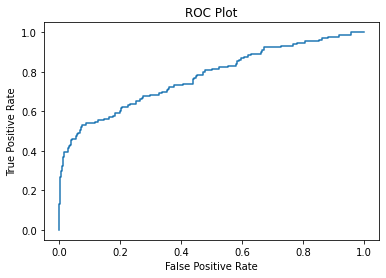

In [63]:
fpr, tpr, _ = roc_curve(test_labels[:,0].numpy(), np.asarray(prediction_logits))

plt.plot(fpr, tpr)
plt.title("ROC Plot")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Hyper parameter tunning 

So far we have trained a single model with fixed hyper parameters. Nest lets try to further optimize the model by traying out different hyper parameters. We can use Amazon SageMaker Hyper parameter tunner for this purpose.

In [ ]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
gcn_hyperparameter_ranges = {
    
    "gnn-dropout": ContinuousParameter(0.001 , 0.003),
    "gnn-predictor-hidden-feats" : CategoricalParameter([128, 256, 512]),
    
    "batch-size" :  CategoricalParameter([256, 512]),
    "learning-rate" : ContinuousParameter(0.0001, 0.001),
    "weight-decay" : ContinuousParameter(0.001, 0.01)
    
}

objective_metric_name = "best validation:roc_auc_score"

gcn_estimator = PyTorch(
    entry_point = "train.py",
    source_dir = "code",
    role = role,
    framework_version = "1.9.0",
    py_version="py38",
    instance_count=2,
    instance_type="ml.g4dn.4xlarge",
    debugger_hook_config=False,
    disable_profiler=True
)

gcn_tuner = HyperparameterTuner(
    gcn_estimator,
    objective_metric_name,
    gcn_hyperparameter_ranges,
    metric_definitions,
    max_jobs=6,
    max_parallel_jobs=2
)

hyper_parameter_job_name = "hpo-hiv-gcn-p-{}".format(time.strftime("%m-%d-%H-%M-%S")) 
print('Training job name: ', hyper_parameter_job_name)

gcn_tuner.fit({"data_full" : input_full, "data_train" : input_train, "data_val" : input_val}, job_name = hyper_parameter_job_name)


Training job name:  hpo-hiv-gcn-p-03-16-07-45-12


INFO:sagemaker:Creating hyperparameter tuning job with name: hpo-hiv-gcn-p-03-16-07-45-12


.......................

In [404]:
# if the notebook lost it's connection, you can attach the tunner job by attaching the name below.
#gcn_tuner = HyperparameterTuner.attach("hpo-hiv-gcn-p-03-16-02-38-07")


Let's examine the best model and it's hyper parameters.

In [ ]:
import boto3

smclient = boto3.client("sagemaker")

best_overall_training_job = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=hyper_parameter_job_name
)

best_overall_training_job["BestTrainingJob"]

In [ ]:
best_gcn_training_job = sagemaker.estimator.Estimator.attach(best_overall_training_job["BestTrainingJob"]["TrainingJobName"])

In [420]:
best_gcn_model = PyTorchModel(model_data=best_gcn_training_job.model_data, source_dir='code',
                        entry_point='inference.py', role=role, framework_version="1.9.0", py_version='py38')

best_gcn_predictor = best_gcn_model.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge", endpoint_name="best-gcn-" + endpoint_name)

INFO:sagemaker:Creating model with name: pytorch-inference-2022-03-16-07-40-28-072
INFO:sagemaker:Creating endpoint with name best-gcn-HIV-Inhibitor-Prediction-EP-03-16-2022-01-45-35


------!

In [421]:
best_gcn_predictor.serializer = sagemaker.serializers.JSONSerializer()
best_gcn_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

json = {
    "smiles" : 
        test_smiles
}

prediction_logits = best_gcn_predictor.predict(json)
roc_auc_score(test_labels[:,0].numpy(), np.asarray(prediction_logits))

0.7665540083817763

## Clean up 

In [ ]:
best_gcn_predictor.delete_endpoint()

In [ ]:
predictor.delete_endpoint()